In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as img
import pandas as pnd
import seaborn as sns
import subprocess
import scipy
import sympy
from symfit import parameters, variables, sin, cos, Fit

pathex = "/home/gabriel/Repositories/colloidal_membranes_v2/data_viz/media"
pathpoints = "/home/gabriel/Repositories/colloidal_membranes_v2/data_viz/extracted_data/single_pore_round_9/PoreBndPoints"

In [2]:
sns.set_theme(font_scale = 1)

In [3]:
#Example 1:
q = 0.5
g = 0.3

In [4]:

pop = "\n"
delimiter = ","
points = open(pathpoints+f"/EdgePointDataq={q}g={g}.txt","r")
data = points.readlines()[1:]
dic = {"id":[], "x":[], "y":[]}
for line in data:
    line = line.replace(pop, "")
    line = line.split(delimiter)
    dic["id"].append(float(line[0]))
    dic["x"].append(float(line[1]))
    dic["y"].append(float(line[2]))
df = pnd.DataFrame(dic)


In [5]:
print(df)

        id         x         y
0    590.0 -0.591746 -1.924630
1    591.0 -0.381281 -2.209470
2    592.0 -0.071046 -2.373550
3    593.0  0.292244 -2.325350
4    594.0  0.571497 -1.950410
5    668.0 -0.732647 -1.497870
6    669.0  0.737000 -1.411680
7    741.0 -0.809811 -0.899643
8    742.0  0.797304 -0.992437
9    812.0 -0.832623 -0.629909
10   813.0  0.854549 -0.570303
11   882.0 -0.853493 -0.296517
12   883.0  0.862858 -0.365285
13   952.0 -0.858451  0.019337
14   953.0  0.866704 -0.172881
15  1022.0 -0.857674  0.180175
16  1023.0  0.864182  0.031411
17  1092.0 -0.848840  0.366014
18  1093.0  0.863450  0.247390
19  1162.0 -0.831879  0.621010
20  1163.0  0.848681  0.523548
21  1233.0 -0.807032  0.902453
22  1234.0  0.807221  0.937179
23  1306.0 -0.677336  1.544670
24  1307.0 -0.569444  1.895400
25  1308.0  0.510575  2.027730
26  1309.0  0.699787  1.483850
27  1384.0 -0.323491  2.170950
28  1385.0 -0.120420  2.312560
29  1386.0  0.199098  2.306230


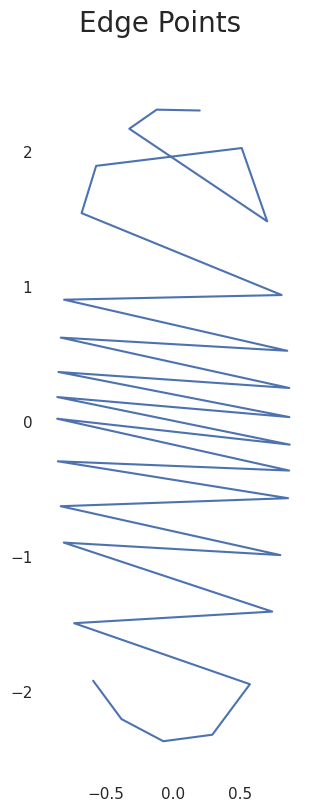

In [6]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(4,8)
fig.suptitle("Edge Points   \n", fontsize=20)
gspec = fig.add_gridspec(1,1, width_ratios= [1])
ax1 = fig.add_subplot(gspec[0,0],  facecolor='white')
ax1.set_aspect('equal')
ax1.plot(df[["x"]].to_numpy(), df[["y"]].to_numpy())


In [7]:
def theta(pt):
    x = pt[0]
    y = pt[1]
    th = np.arctan2(y, x)
    return th

da = df[["x", "y"]].to_numpy()
da = np.stack(sorted(da, key = theta))
print(da)

[[-0.85349298 -0.29651701]
 [-0.832623   -0.62990898]
 [-0.809811   -0.899643  ]
 [-0.732647   -1.49786997]
 [-0.59174597 -1.92463005]
 [-0.38128099 -2.20947003]
 [-0.071046   -2.37354994]
 [ 0.29224399 -2.32535005]
 [ 0.57149702 -1.95041001]
 [ 0.73699999 -1.41167998]
 [ 0.79730397 -0.99243701]
 [ 0.85454899 -0.57030302]
 [ 0.862858   -0.36528501]
 [ 0.86670399 -0.17288101]
 [ 0.864182    0.0314108 ]
 [ 0.86344999  0.24739   ]
 [ 0.84868097  0.52354801]
 [ 0.807221    0.93717903]
 [ 0.69978702  1.48385   ]
 [ 0.510575    2.02772999]
 [ 0.19909801  2.30623007]
 [-0.12042     2.31256008]
 [-0.32349101  2.17094994]
 [-0.569444    1.89540005]
 [-0.67733598  1.54466999]
 [-0.80703199  0.90245301]
 [-0.83187902  0.62101001]
 [-0.84884     0.366014  ]
 [-0.857674    0.18017501]
 [-0.85845101  0.0193372 ]]


In [8]:
Th = np.stack([theta(da[i]) for i in range(0, len(da))])
R = np.stack([np.linalg.norm(da[i])for i in range(0, len(da))])

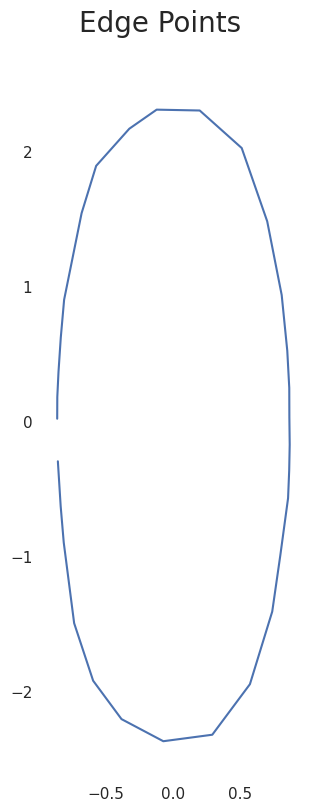

In [9]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(4,8)
fig.suptitle("Edge Points   \n", fontsize=20)
gspec = fig.add_gridspec(1,1, width_ratios= [1])
ax1 = fig.add_subplot(gspec[0,0],  facecolor='white')
ax1.set_aspect('equal')
ax1.plot(da[:,0], da[:,1])

In [10]:
def fourier_series(x, f, n=0, cos_a_initial=None, sin_b_initial=None):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    if cos_a_initial != None and sin_b_initial != None:
        a0.value(cos_a_initial[0])
        for i in range(0, n):
            cos_a[i].value(cos_a_initial[i+1])
            sin_b[i].value(sin_b_initial[i])
    
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

th, r = variables('th, r')
w, = parameters('w')
model_dict = {r: fourier_series(th, f=w, n=4)}
print(model_dict)

{r: a0 + a1*cos(w*th) + a2*cos(2*w*th) + a3*cos(3*w*th) + a4*cos(4*w*th) + b1*sin(w*th) + b2*sin(2*w*th) + b3*sin(3*w*th) + b4*sin(4*w*th)}



Parameter Value        Standard Deviation
a0        1.368620e+00 5.071372e-03
a1        -6.750771e-01 6.613800e-03
a2        2.282508e-01 6.927334e-03
a3        -7.533544e-02 6.997640e-03
a4        1.698866e-02 6.587707e-03
b1        3.244258e-03 7.206168e-03
b2        -5.622175e-03 6.896810e-03
b3        3.445314e-03 6.726117e-03
b4        -8.184885e-04 7.079455e-03
w         2.004536e+00 4.761345e-03
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   30
Objective              <symfit.core.objectives.LeastSquares object at 0x7fe4f13d1970>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7fe46cb20e00>

Goodness of fit qualifiers:
chi_squared            0.013314897015011706
objective_value        0.006657448507505853
r_squared              0.9985509524358457

 C notation: 

var a0 = 1.3686203985968723
var a1 = -0.6750771104779721
var a2 = 0.22825083716929517
var a3 = -0.07533543752125009
var a4 = 0.0169886631982668

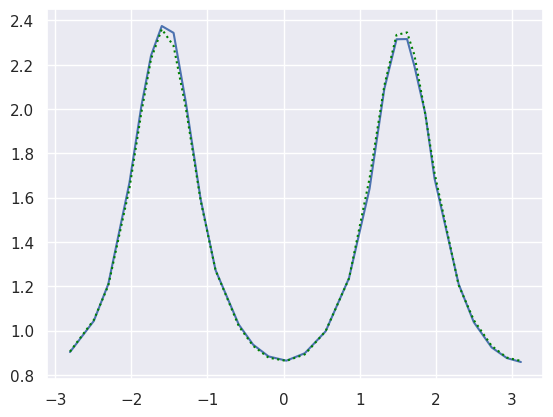

In [11]:
fit = Fit(model_dict, th=Th, r=R)
fit_result = fit.execute()

print(fit_result)
print("\n C notation: \n")
ps  = fit_result.params



print("var a0 = "+str(ps["a0"]))
print("var a1 = "+str(ps["a1"]))
print("var a2 = "+str(ps["a2"]))
print("var a3 = "+str(ps["a3"]))
print("var a4 = "+str(ps["a4"]))
# print("var a5 = "+str(ps["a5"]))

print("var b1 = "+str(ps["b1"]))
print("var b2 = "+str(ps["b2"]))
print("var b3 = "+str(ps["b3"]))
print("var b4 = "+str(ps["b4"]))
# print("var b5 = "+str(ps["b5"]))

print("var w = "+str(ps["w"]))



# Plot the result
plt.plot(Th, R)
plt.plot(Th, fit.model(th=Th, **fit_result.params).r, color='green', ls=':')

In [12]:
# Example 2
q = 0.8
g = 0.3

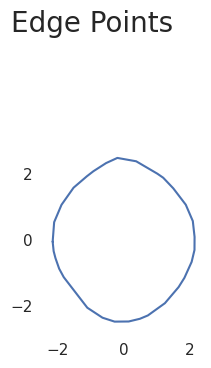


Parameter Value        Standard Deviation
a0        2.241857e+00 3.010381e-03
a1        -1.402151e-01 4.193120e-03
a2        6.636348e-02 4.182610e-03
a3        -1.765697e-02 4.212121e-03
a4        6.558716e-03 4.162432e-03
a5        -8.449262e-03 4.195473e-03
a6        1.583518e-03 4.162177e-03
a7        -1.672744e-03 4.164578e-03
a8        2.870062e-05 4.161819e-03
b1        -7.093216e-03 4.187207e-03
b2        -5.646070e-03 4.156106e-03
b3        3.105893e-03 4.267318e-03
b4        -2.654444e-04 4.222604e-03
b5        -2.938881e-03 4.201347e-03
b6        -2.547464e-03 4.155810e-03
b7        6.954824e-04 4.171076e-03
b8        2.584864e-04 4.156448e-03
w         1.976598e+00 1.334251e-02
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   46
Objective              <symfit.core.objectives.LeastSquares object at 0x7fe46caa2150>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7fe46cad2f60>

Goodness of fit qualifie

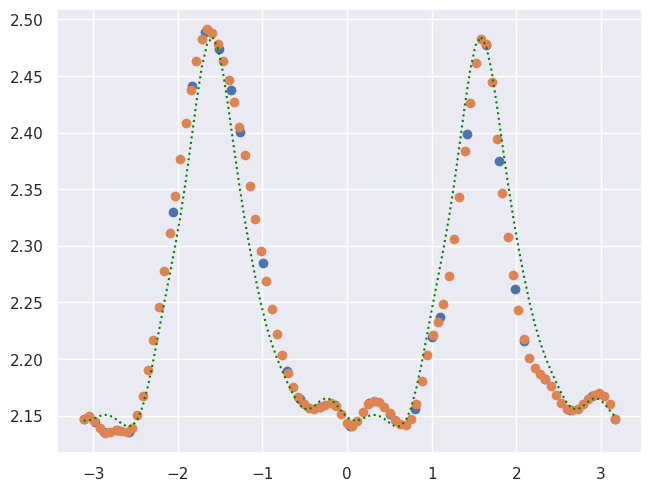

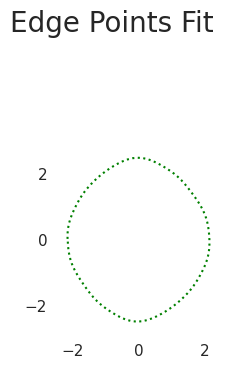

In [13]:
model_dict = {r: fourier_series(th, f=w, n=8)}
#Initial Guess


pop = "\n"
delimiter = ","
points = open(pathpoints+f"/EdgePointDataq={q}g={g}.txt","r")
data = points.readlines()[1:]
dic = {"id":[], "x":[], "y":[]}
for line in data:
    line = line.replace(pop, "")
    line = line.split(delimiter)
    dic["id"].append(float(line[0]))
    dic["x"].append(float(line[1]))
    dic["y"].append(float(line[2]))
df = pnd.DataFrame(dic)
def theta(pt):
    x = pt[0]
    y = pt[1]
    th = np.arctan2(y, x)
    return th

da = df[["x", "y"]].to_numpy()
da = np.stack(sorted(da, key = theta))
da = np.vstack([da, da[0]])
Th = np.stack([theta(da[i]) for i in range(0, len(da))])
Th[-1] += 2*np.pi
R = np.stack([np.linalg.norm(da[i])for i in range(0, len(da))])

from scipy import interpolate
moreTh = np.linspace(np.min(Th), np.max(Th), 100)
f = interpolate.interp1d(Th,R,kind='cubic')
moreR = f(moreTh)



fit = Fit(model_dict, th=moreTh, r=moreR)
fit_result = fit.execute()


fig = plt.figure(constrained_layout=True)
fig.set_size_inches(2,4)
fig.suptitle("Edge Points   \n", fontsize=20)
gspec = fig.add_gridspec(1,1, width_ratios= [1])
ax1 = fig.add_subplot(gspec[0,0],  facecolor='white')
ax1.set_aspect('equal')
ax1.plot(da[:,0], da[:,1])
plt.show()
print(fit_result)
print("\n C notation: \n")
ps  = fit_result.params



print("var a0 = "+str(ps["a0"]))
print("var a1 = "+str(ps["a1"]))
print("var a2 = "+str(ps["a2"]))
print("var a3 = "+str(ps["a3"]))
print("var a4 = "+str(ps["a4"]))
print("var a5 = "+str(ps["a5"]))
print("var a6 = "+str(ps["a6"]))
print("var a7 = "+str(ps["a7"]))
print("var a8 = "+str(ps["a8"]))

print("var b1 = "+str(ps["b1"]))
print("var b2 = "+str(ps["b2"]))
print("var b3 = "+str(ps["b3"]))
print("var b4 = "+str(ps["b4"]))
print("var b5 = "+str(ps["b5"]))
print("var b6 = "+str(ps["b6"]))
print("var b7 = "+str(ps["b7"]))
print("var b8 = "+str(ps["b8"]))

print("var w = "+str(ps["w"]))
print("\n")
print("R(th) = "+str(model_dict[r]))
print("\n")

# Plot the result
fig = plt.figure(constrained_layout=True)
plt.scatter(Th, R)
plt.scatter(moreTh, moreR)

plt.plot(moreTh, fit.model(th=moreTh, **fit_result.params).r, color='green', ls=':')


fig = plt.figure(constrained_layout=True)
fig.set_size_inches(2,4)
fig.suptitle("Edge Points Fit  \n", fontsize=20)
gspec = fig.add_gridspec(1,1, width_ratios= [1])
ax1 = fig.add_subplot(gspec[0,0],  facecolor='white')
ax1.set_aspect('equal')
# plt.plot(R*np.cos(Th), R*np.sin(Th))
plt.plot(fit.model(th=moreTh, **fit_result.params).r*np.cos(moreTh), fit.model(th=moreTh, **fit_result.params).r*np.sin(moreTh), color='green', ls=':')

plt.show()
# plt.plot(moreTh, fit.model(th=moreTh, **fit_result.params).r, color='green', ls=':')


In [14]:
from scipy import integrate
np.set_printoptions(legacy='1.25')

# Differentiate the expression with respect to x

derivative = sympy.diff(model_dict[r], th)
th = sympy.symbols("th")
w = sympy.symbols("w")
a0, a1, a2, a3, a4, a5, a6, a7, a8 = sympy.symbols("a0 a1 a2 a3 a4 a5 a6 a7 a8")
b1, b2, b3, b4, b5, b6, b7, b8 = sympy.symbols("b1 b2 b3 b4 b5 b6 b7 b8")


# radius = a0 + a1*cos(w*th) + a2*cos(2*w*th) + a3*cos(3*w*th) + a4*cos(4*w*th) + b1*sin(w*th) + b2*sin(2*w*th) + b3*sin(3*w*th) + b4*sin(4*w*th) 
# derived = -a1*w*sin(w*th) - 2*a2*w*sin(2*w*th) - 3*a3*w*sin(3*w*th) - 4*a4*w*sin(4*w*th) + b1*w*cos(w*th) + 2*b2*w*cos(2*w*th) + 3*b3*w*cos(3*w*th) + 4*b4*w*cos(4*w*th)
# radius = radius.subs([(w, ps["w"]),(a0, ps["a0"]),(a1, ps["a1"]),(a2, ps["a2"]),(a3, ps["a3"]),(a4, ps["a4"]),(b1, ps["b1"]),(b2, ps["b2"]),(b3, ps["b3"]),(b4, ps["b4"])])
# derived = derived.subs([(w, ps["w"]),(a1, ps["a1"]),(a2, ps["a2"]),(a3, ps["a3"]),(a4, ps["a4"]),(b1, ps["b1"]),(b2, ps["b2"]),(b3, ps["b3"]),(b4, ps["b4"])])



radius = a0 + a1*cos(w*th) + a2*cos(2*w*th) + a3*cos(3*w*th) + a4*cos(4*w*th) + a5*cos(5*w*th) + a6*cos(6*w*th) + a7*cos(7*w*th) + a8*cos(8*w*th) + b1*sin(w*th) + b2*sin(2*w*th) + b3*sin(3*w*th) + b4*sin(4*w*th) + b5*sin(5*w*th) + b6*sin(6*w*th) + b7*sin(7*w*th) + b8*sin(8*w*th)
derived = -a1*w*sin(w*th) - 2*a2*w*sin(2*w*th) - 3*a3*w*sin(3*w*th) - 4*a4*w*sin(4*w*th) - 5*a5*w*sin(5*w*th) - 6*a6*w*sin(6*w*th) - 7*a7*w*sin(7*w*th) - 8*a8*w*sin(8*w*th) + b1*w*cos(w*th) + 2*b2*w*cos(2*w*th) + 3*b3*w*cos(3*w*th) + 4*b4*w*cos(4*w*th) + 5*b5*w*cos(5*w*th) + 6*b6*w*cos(6*w*th) + 7*b7*w*cos(7*w*th) + 8*b8*w*cos(8*w*th)
# Print the result
radius = radius.subs([(w, ps["w"]),(a0, ps["a0"]),(a1, ps["a1"]),(a2, ps["a2"]),(a3, ps["a3"]),(a4, ps["a4"]),(a5, ps["a5"]),(a6, ps["a6"]),(a7, ps["a7"]),(a8, ps["a8"]),(b1, ps["b1"]),(b2, ps["b2"]),(b3, ps["b3"]),(b4, ps["b4"]),(b5, ps["b5"]),(b6, ps["b6"]),(b7, ps["b7"]),(b8, ps["b8"])])
derived = derived.subs([(w, ps["w"]),(a1, ps["a1"]),(a2, ps["a2"]),(a3, ps["a3"]),(a4, ps["a4"]),(a5, ps["a5"]),(a6, ps["a6"]),(a7, ps["a7"]),(a8, ps["a8"]),(b1, ps["b1"]),(b2, ps["b2"]),(b3, ps["b3"]),(b4, ps["b4"]),(b5, ps["b5"]),(b6, ps["b6"]),(b7, ps["b7"]),(b8, ps["b8"])])
d = sympy.lambdify(th, derived)
rd = sympy.lambdify(th, radius)

# plt.plot(moreTh, d(moreTh))
# plt.plot(moreTh, r(moreTh))
result = integrate.trapezoid(np.sqrt((rd(moreTh))**2+(d(moreTh))**2), x=moreTh)
print([round(i*result, 6) for i in np.arange(0.025, 1.025, 0.025)])

[0.355201, 0.710402, 1.065603, 1.420805, 1.776006, 2.131207, 2.486408, 2.841609, 3.19681, 3.552011, 3.907212, 4.262414, 4.617615, 4.972816, 5.328017, 5.683218, 6.038419, 6.39362, 6.748821, 7.104023, 7.459224, 7.814425, 8.169626, 8.524827, 8.880028, 9.235229, 9.59043, 9.945632, 10.300833, 10.656034, 11.011235, 11.366436, 11.721637, 12.076838, 12.432039, 12.787241, 13.142442, 13.497643, 13.852844, 14.208045]


In [15]:
for i,s in enumerate([1,2,3,4,2]):
    print(i,s)

0 1
1 2
2 3
3 4
4 2
